## Q-learning for NChain with Open AI Gym

The NChain example on Open AI Gym is a simple 5 state environment. There are two possible actions in each state, move forward (action 0) and move backwards (action 1). 

The diagram below demonstrates this environment:

![Open AI Gym's NChain environment](https://i0.wp.com/adventuresinmachinelearning.com/wp-content/uploads/2018/02/NChain-illustration.png?w=906&ssl=1)

In order to train the agent effectively, we need to find a good policy $\pi$ which maps states to actions in an optimal way to maximize reward. There are various ways of going about finding a good or optimal policy. 

In [1]:
import gym
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, InputLayer

Using TensorFlow backend.


In [2]:
# environment is loaded
env = gym.make('NChain-v0')

In [3]:
env.reset()

0

In [4]:
# action ID == 1
action_id = 1
env.step(action_id)

(1, 0, False, {})

The environment returns the new state, the reward for this action, whether the game is “done” at this stage and the debugging information.

In [5]:
# returns 4 variables: new state after the action, reward due to the action, 
# Whether the game is “done” or not – the NChain game is done after 1,000 steps, Debugging information 
env.step(0)

(2, 0, False, {})

In [6]:
env.step(0)

(3, 0, False, {})

In [7]:
env.step(0)

(4, 0, False, {})

### Naive reinforcement learning

The agent training model using Q learning, the action selection policy is based solely on the maximum Q value in any given state. It is conceivable that, given the random nature of the environment, that the agent initially makes “bad” decisions. The Q values arising from these decisions may easily be “locked in” – and from that time forward, bad decisions may continue to be made by the agent because it can only ever select the maximum Q value in any given state, even if these values are not necessarily optimal. This action selection policy is called a greedy policy.

In [8]:
# policy – choose the action resulting in the greatest previous summated reward
def naive_sum_reward_agent(env, num_episodes=500):
    # this is the table that will hold our summated rewards for
    # each action in each state
    r_table = np.zeros((5, 2))
    
    for g in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            if np.sum(r_table[s, :]) == 0:
                # make a random selection of actions
                a = np.random.randint(0, 2)
            else:
                # select the action with highest cummulative reward
                a = np.argmax(r_table[s, :])
                
            new_s, r, done, _ = env.step(a)
            # naive learning rule
            r_table[s, a] += r
            s = new_s
            
    return r_table

Wit this approach will lead to the table being “locked in” with respect to actions after just a few steps in the game, and this model for training the agent has no way to encourage acting on delayed reward signal when it is appropriate for it to do so.

### Delayed reward reinforcement learning

This idea of propagating possible reward from the best possible actions in future states is a core component of what is called Q learning. In Q learning, the Q value for each action in each state is updated when the relevant information is made available. Return of the maximum Q value for the best possible action in the next state. In this way, the agent is looking forward to determine the best possible future rewards before making the next step.

In [9]:
def q_learning_with_table(env, num_episodes=500):
    y = 0.95
    lr = 0.8
    q_table = np.zeros((5, 2))
    
    for i in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            if np.sum(q_table[s,:]) == 0:
                # make a random selection of actions
                a = np.random.randint(0, 2)
            else:
                # select the action with largest q value in state s
                a = np.argmax(q_table[s, :]) # the action with the highest q value.
                
            new_s, r, done, _ = env.step(a)
            # Q learning rule
            q_table[s, a] += r + lr*(y*np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
            
    return q_table

With this approach there isn’t enough exploration going on within the agent training method.

### Q learning with ϵ-greedy action selection reinforcement learning

We need a way for the agent to eventually always choose the “best” set of actions in the environment, yet at the same time allowing the agent to not get “locked in” and giving it some space to explore alternatives. What is required is the  ϵ-greedy policy.

In [10]:
def eps_greedy_q_learning_with_table(env, num_episodes=500):
    y = 0.95
    eps = 0.5
    lr = 0.8
    decay_factor = 0.999
    q_table = np.zeros((5, 2))
    
    for i in range(num_episodes):
        s = env.reset()
        eps *= decay_factor
        done = False
        
        while not done:
            # select the action with highest cummulative reward
            if np.random.random() < eps or np.sum(q_table[s, :]) == 0:
                a = np.random.randint(0, 2) # the action will be selected randomly from the two possible actions in each state. 
            else:
                a = np.argmax(q_table[s, :]) # taking the action with the highest q value.
                
            # pdb.set_trace()
            new_s, r, done, _ = env.step(a)
            q_table[s, a] += r + lr * (y * np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
            
    return q_table

The ϵ-greedy policy in reinforcement learning is basically the same as the greedy policy, except that there is a value ϵ (which may be set to decay over time) where, if a random number is selected which is less than this value, an action is chosen completely at random. This step allows some random exploration of the value of various actions in various states, and can be scaled back over time to allow the algorithm to concentrate more on exploiting the best strategies that it has found.

## Comparing the methods

Check which of the last agent training models actually produces an agent that gathers the most rewards in any given game, to see which agent performs the best over a test game.

 The models are trained as well as tested in each iteration because there is significant variability in the environment which messes around with the efficacy of the training – so this is an attempt to understand average performance of the different models. 

In [11]:
def run_game(table, env):
    
    s = env.reset()
    tot_reward = 0
    done = False
    
    while not done:
        a = np.argmax(table[s, :])
        s, r, done, _ = env.step(a)      
        tot_reward += r
        
    return tot_reward

In [12]:
def test_methods(env, num_iterations=100):
    winner = np.zeros((3,))
    
    for g in range(num_iterations):
        
        m0_table = naive_sum_reward_agent(env, 500)
        m1_table = q_learning_with_table(env, 500)
        m2_table = eps_greedy_q_learning_with_table(env, 500)
        
        m0 = run_game(m0_table, env)
        m1 = run_game(m1_table, env)
        m2 = run_game(m2_table, env)
        
        w = np.argmax(np.array([m0, m1, m2]))
        winner[w] += 1
        
        if g % 100 == 0:
            print("Game {} of {}".format(g + 1, num_iterations))
        
    return winner

In [13]:
%%time
# executing reinforcement learning to run NChain game
test_methods(env)

Game 1 of 100
Game 2 of 100
Game 3 of 100
Game 4 of 100
Game 5 of 100
Game 6 of 100
Game 7 of 100
Game 8 of 100
Game 9 of 100
Game 10 of 100
Game 11 of 100
Game 12 of 100
Game 13 of 100
Game 14 of 100
Game 15 of 100
Game 16 of 100
Game 17 of 100
Game 18 of 100
Game 19 of 100
Game 20 of 100
Game 21 of 100
Game 22 of 100
Game 23 of 100
Game 24 of 100
Game 25 of 100
Game 26 of 100
Game 27 of 100
Game 28 of 100
Game 29 of 100
Game 30 of 100
Game 31 of 100
Game 32 of 100
Game 33 of 100
Game 34 of 100
Game 35 of 100
Game 36 of 100
Game 37 of 100
Game 38 of 100
Game 39 of 100
Game 40 of 100
Game 41 of 100
Game 42 of 100
Game 43 of 100
Game 44 of 100
Game 45 of 100
Game 46 of 100
Game 47 of 100
Game 48 of 100
Game 49 of 100
Game 50 of 100
Game 51 of 100
Game 52 of 100
Game 53 of 100
Game 54 of 100
Game 55 of 100
Game 56 of 100
Game 57 of 100
Game 58 of 100
Game 59 of 100
Game 60 of 100
Game 61 of 100
Game 62 of 100
Game 63 of 100
Game 64 of 100
Game 65 of 100
Game 66 of 100
Game 67 of 100
Game

array([11., 12., 77.])

As can be observed, of the 100 experiments the ϵ-greedy, Q learning algorithm wins 65 of them. This is followed by the standard greedy implementation of Q learning, which won 22 of the experiments. Finally the naive accumulated rewards method only won 13 experiments. So as can be seen, the ϵ-greedy Q learning method is quite an effective way of executing reinforcement learning.

Here, it can be observed that the trained table given to the function is used for action selection, and the total reward accumulated during the game is returned.

We have been dealing with explicit tables to hold information about the best actions and which actions to choose in any given state, perfectly reasonable approach for a small environment, the table gets far too large and unwieldy for more complicated environments which have a huge number of states and potential actions.

This is where neural networks can be used in reinforcement learning. Instead of having explicit tables, instead we can train a neural network to predict Q values for each action in a given state.

## Reinforcement learning with neural networks

To develop a neural network which can perform Q learning, the input needs to be the current state (plus potentially some other information about the environment) and it needs to output the relevant Q values for each action in that state. The Q values which are output should approach, as training progresses, the values produced in the Q learning updating rule. 

 The loss function for the neural network should be:
 
 $loss=(r+\gamma max_{a'} Q'(s',a') - Q(s,a))$,
 
 where $r+\gamma max_{a'} Q'(s',a')$ is the target and Q(s,a) is the prediction.


In [14]:
model = Sequential()
# The input to the network is the one-hot encoded state vector 
# (e.g. state 1 is [0, 1, 0, 0, 0] and state 3 is [0, 0, 0, 1, 0]).
model.add(InputLayer(batch_input_shape=(1, 5)))
model.add(Dense(10, activation='sigmoid'))
# Two Q values assigned to each state to represent the two possible actions.
model.add(Dense(2, activation='linear'))
#model.add(BatchNormalization(axis = 3))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

Instructions for updating:
Colocations handled automatically by placer.


We define a fuction too call this model in the training environment, ϵ -greedy Q learning methodology with a deep neural network as opposed to an explicit Q table.

In [15]:
def eps_greedy_deep_q_learning(env, num_episodes=500):
    # now execute the q learning
    y = 0.95
    eps = 0.5
    decay_factor = 0.999
    r_avg_list = []
    
    for i in range(num_episodes):
        s = env.reset()
        eps *= decay_factor
        
        if i % 100 == 0:
            print("Episode {} of {}".format(i + 1, num_episodes))
            
        done = False
        r_sum = 0
        
        while not done:
            if np.random.random() < eps:
                a = np.random.randint(0, 2)
            else:
                a = np.argmax(model.predict(np.identity(5)[s:s + 1]))
                
            new_s, r, done, _ = env.step(a)
            
            target = r + y * np.max(model.predict(np.identity(5)[new_s:new_s + 1]))
            
            target_vec = model.predict(np.identity(5)[s:s + 1])[0]
            target_vec[a] = target
            
            model.fit(np.identity(5)[s:s + 1], 
                      target_vec.reshape(-1, 2), 
                      epochs=1, verbose=0)
            
            s = new_s
            r_sum += r
            
        r_avg_list.append(r_sum / 1000)
        
    return r_avg_list

In [16]:
%%time
rList = eps_greedy_deep_q_learning(env)

Episode 1 of 500
Instructions for updating:
Use tf.cast instead.
Episode 101 of 500
Episode 201 of 500
Episode 301 of 500
Episode 401 of 500


Running this training over 1000 game episodes reveals the following average reward for each step in the game.

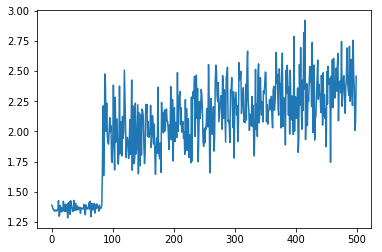

In [19]:
import matplotlib.pyplot as plt 
plt.plot(rList)
plt.show()

As can be observed, the average reward per step in the game increases over each game episode. We also get an output of the Q values for each of the states - we can see that the Q values for each state will favor choosing action 0 (moving forward) to shoot for those big, repeated rewards in state 4. Intuitively, this seems like the best strategy.